In [14]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Importacion y preprocesamiento de datos

In [60]:
direccion=r"C:/Users/Guille/Desktop/Clustering_Guille/dataset_csv/Metropolitano142.csv"
df = pd.DataFrame()
df = pd.read_csv(direccion)

df["Hora"]=pd.to_datetime(df["Hora"],  format='%Y-%m-%d %H:%M:%S',dayfirst=True)
df.rename(columns={"Hora": "Fecha"}, inplace=True)
df['Hora'] = df['Fecha'].dt.hour

# cortamos el rango que no nos sirve
df=df[df["Fecha"]>'2022-01-07 23:00:00']
extra_rows = len(df) % 24
if extra_rows != 0:
    df = df.iloc[:-extra_rows]

# hallamos los valores vacios y los llenamos con el valor promedio de su columna
nan_columns = df.columns[df.isnull().any()].tolist()
df[nan_columns] = df[nan_columns].fillna(df[nan_columns].mean())

data=df.copy()
data["Fecha"]=pd.to_datetime(data["Fecha"],dayfirst=True)
data = data.set_index('Fecha')
data.pop(data.columns.values[-1])

data # 121 usuarios, 552 horas = 23 días

,171,170,169,168,167,166,165,164,163,162,...,60,59,58,57,56,55,54,53,52,51
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,2.656,1.936,3.420,0.332,2.402,3.626000,2.994,1.340,2.222000,4.986,...,0.924,1.568,1.882,3.208,0.112,1.920,1.596,2.594,0.922,2.852
2022-01-08 01:00:00,2.204,1.504,3.680,0.324,2.998,3.024000,4.178,1.262,2.044000,3.656,...,0.242,1.460,1.942,2.864,0.112,1.418,1.722,2.018,2.572,2.748
2022-01-08 02:00:00,2.188,1.452,2.676,0.674,2.772,2.758000,3.858,0.956,1.766000,3.268,...,0.624,0.202,1.922,2.602,0.108,1.024,1.548,1.992,2.798,2.572
2022-01-08 03:00:00,1.924,1.398,2.508,0.366,5.884,1.028000,3.418,0.194,3.506000,3.308,...,0.352,0.158,1.850,2.260,0.108,0.988,2.754,1.922,2.418,2.556
2022-01-08 04:00:00,1.796,1.412,2.280,0.320,6.868,0.520000,3.352,0.230,3.122000,4.306,...,0.234,0.086,1.832,1.922,0.106,0.474,2.776,1.898,1.626,1.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30 19:00:00,1.306,1.208,3.300,2.590,0.662,1.797503,0.872,2.014,3.081973,1.572,...,0.070,0.030,2.640,0.746,0.300,2.172,2.618,0.960,0.244,2.678
2022-01-30 20:00:00,0.748,0.796,3.478,3.944,0.712,1.797503,0.724,1.980,3.081973,2.266,...,0.068,0.174,2.404,1.236,0.296,1.812,2.460,1.206,0.200,2.836
2022-01-30 21:00:00,1.760,0.584,3.176,3.120,0.704,1.797503,0.852,1.462,3.081973,3.260,...,0.062,0.794,2.070,0.984,0.288,2.722,2.170,2.958,0.818,2.358


# Periodograma de Lomb-Scargle

In [61]:
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

c:\Users\Guille\anaconda3\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:134: RuntimeWarning: invalid value encountered in divide
  power /= YY



Cantidad de usuarios con energía > 0.0015: 93
Usuarios con energía alta: ['170', '167', '166', '164', '163', '162', '161', '160', '159', '158', '157', '156', '155', '153', '152', '151', '149', '148', '147', '145', '143', '142', '137', '136', '135', '134', '133', '132', '130', '129', '128', '127', '126', '125', '123', '122', '121', '120', '119', '115', '114', '113', '112', '111', '110', '109', '108', '107', '105', '104', '103', '102', '101', '100', '99', '98', '97', '94', '92', '91', '90', '89', '88', '87', '86', '84', '83', '82', '81', '80', '79', '78', '77', '76', '74', '72', '70', '69', '68', '67', '66', '65', '64', '63', '62', '60', '59', '58', '56', '55', '53', '52', '51']
Usuarios con energía baja: ['171', '169', '168', '165', '154', '150', '146', '144', '141', '140', '139', '138', '131', '124', '118', '117', '116', '106', '96', '95', '93', '85', '75', '73', '71', '61', '57', '54']


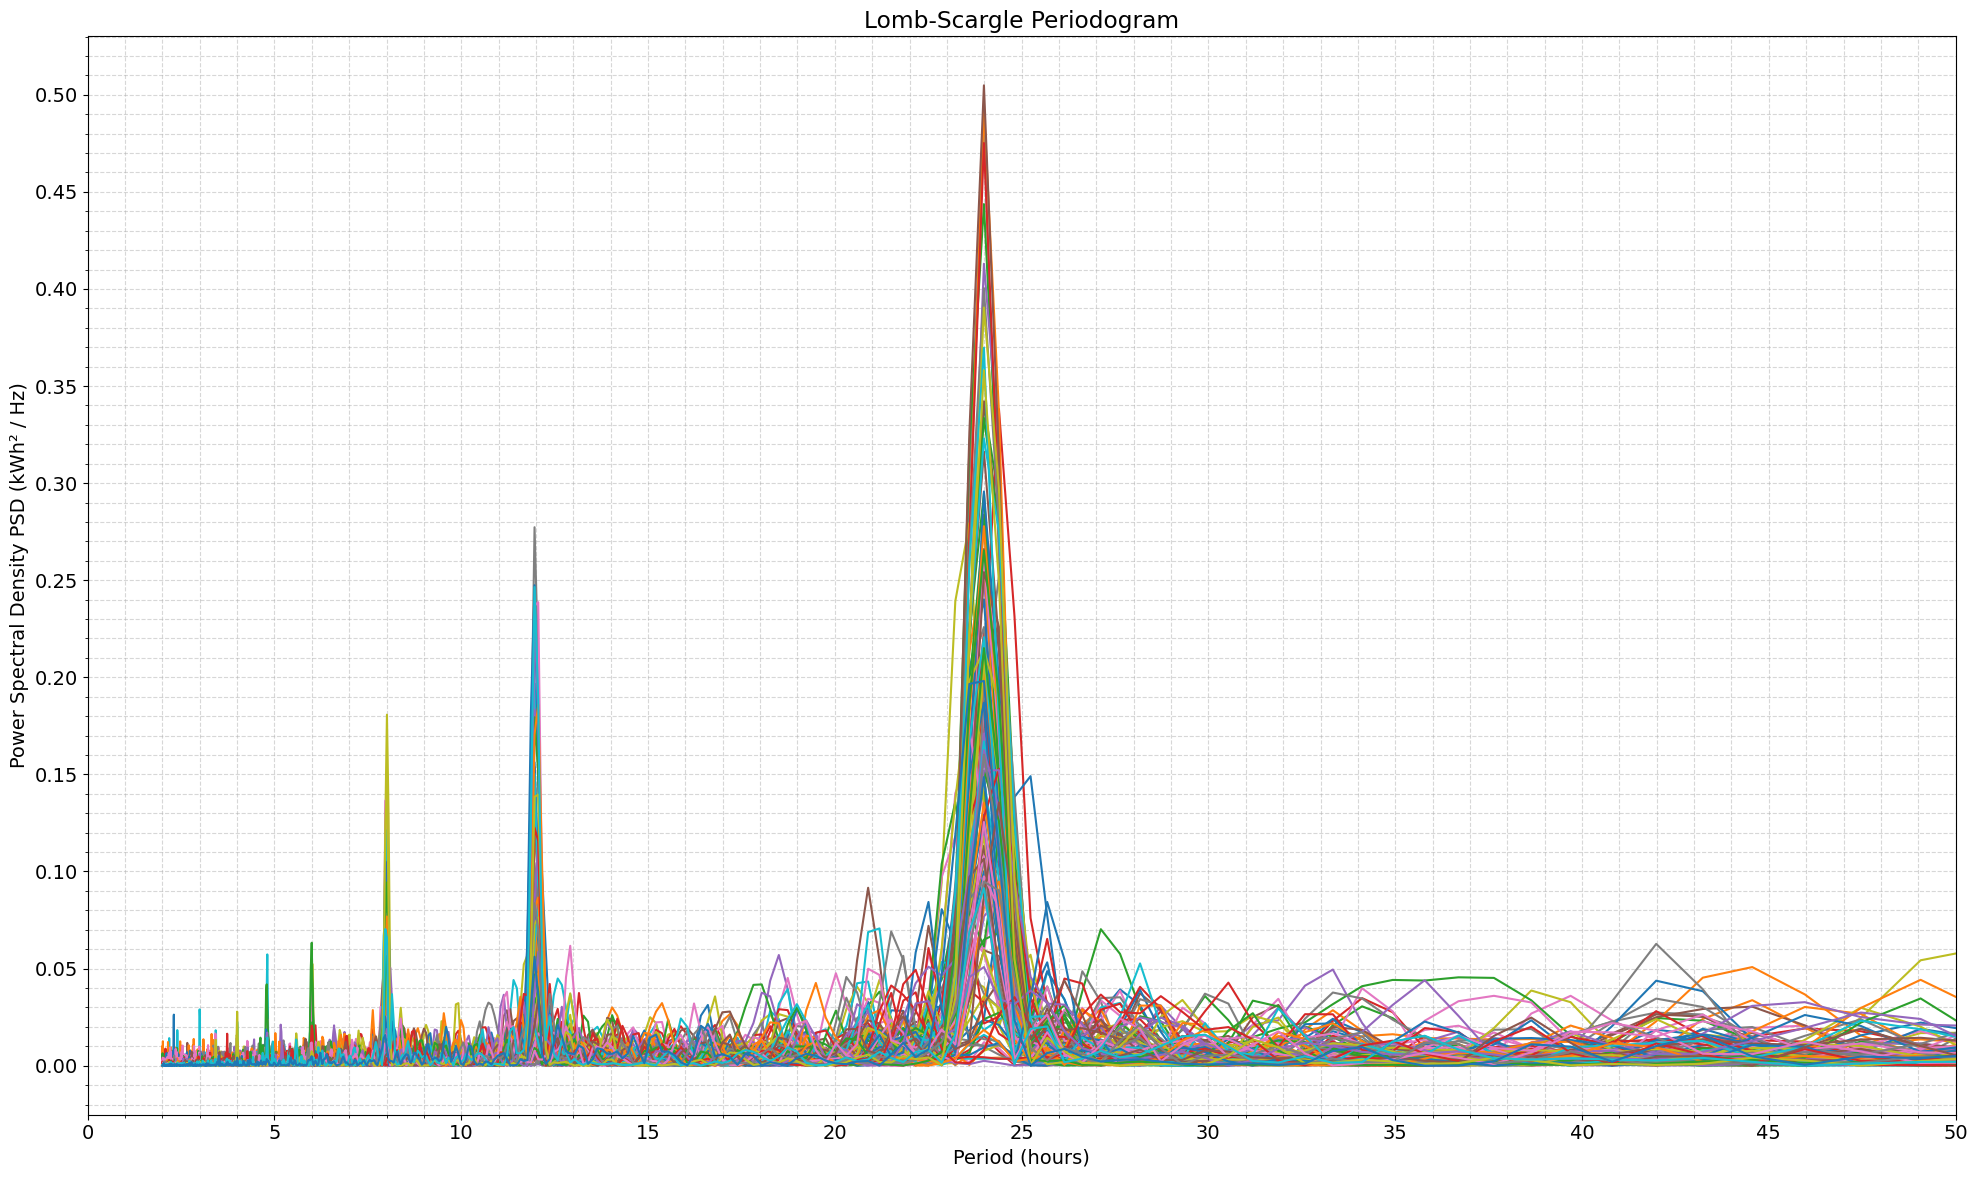

In [62]:

num_usuarios_a_mostrar = 121
usuarios_seleccionados = data.columns[:num_usuarios_a_mostrar]

# Convertimos el índice (fechas) a valores numéricos en horas
time = (data.index - data.index[0]).total_seconds() / 3600

plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 14})

frequencies = np.linspace(1/(1*168), 1/2, 720)  # Frecuencias en Hz
delta_f = frequencies[1] - frequencies[0]       # Resolución de frecuencia

usuarios_energia_alta = []
usuarios_energia_baja = []

umbral_energia = 0.0015  # Ajusta este valor según tus datos

for usuario in usuarios_seleccionados:
    consumo_usuario = data[usuario].dropna()
    tiempo_usuario = time[data[usuario].notna()]
    
    ls = LombScargle(tiempo_usuario, consumo_usuario)
    power_spectrum = ls.power(frequencies)
    periods = frequencies**-1
    plt.plot(periods, power_spectrum, label=f'{usuario}')

    max_psd = np.max(power_spectrum)
    energia_total = np.sum(power_spectrum) * delta_f  # <--- Cálculo de energía

    if energia_total > umbral_energia:
        usuarios_energia_alta.append(usuario)
    else:
        usuarios_energia_baja.append(usuario)

print(f"\nCantidad de usuarios con energía > {umbral_energia}: {len(usuarios_energia_alta)}")
print("Usuarios con energía alta:", usuarios_energia_alta)
print("Usuarios con energía baja:", usuarios_energia_baja)

# Personalizar el gráfico
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlim(0, 50)
plt.xlabel('Period (hours)')
plt.ylabel('Power Spectral Density PSD (kWh² / Hz)')
plt.title('Lomb-Scargle Periodogram')
plt.tight_layout()
#plt.legend(loc='upper right')
plt.show()

In [63]:
data = data.drop(['171', '169', '165', '154', '140', '139', '138', '131', '124', '116', '96', '85', '75', '57', '54'], axis=1)
data

,170,168,167,166,164,163,162,161,160,159,...,62,61,60,59,58,56,55,53,52,51
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,1.936,0.332,2.402,3.626000,1.340,2.222000,4.986,0.662,0.008000,0.764,...,5.288,0.176,0.924,1.568,1.882,0.112,1.920,2.594,0.922,2.852
2022-01-08 01:00:00,1.504,0.324,2.998,3.024000,1.262,2.044000,3.656,1.228,0.008000,1.332,...,3.434,0.246,0.242,1.460,1.942,0.112,1.418,2.018,2.572,2.748
2022-01-08 02:00:00,1.452,0.674,2.772,2.758000,0.956,1.766000,3.268,3.518,0.008000,1.168,...,1.664,0.258,0.624,0.202,1.922,0.108,1.024,1.992,2.798,2.572
2022-01-08 03:00:00,1.398,0.366,5.884,1.028000,0.194,3.506000,3.308,4.208,0.006000,1.018,...,1.596,0.370,0.352,0.158,1.850,0.108,0.988,1.922,2.418,2.556
2022-01-08 04:00:00,1.412,0.320,6.868,0.520000,0.230,3.122000,4.306,5.350,0.008000,0.970,...,1.536,0.274,0.234,0.086,1.832,0.106,0.474,1.898,1.626,1.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30 19:00:00,1.208,2.590,0.662,1.797503,2.014,3.081973,1.572,3.694,0.009985,2.010,...,1.004,2.178,0.070,0.030,2.640,0.300,2.172,0.960,0.244,2.678
2022-01-30 20:00:00,0.796,3.944,0.712,1.797503,1.980,3.081973,2.266,2.458,0.009985,0.532,...,3.226,0.244,0.068,0.174,2.404,0.296,1.812,1.206,0.200,2.836
2022-01-30 21:00:00,0.584,3.120,0.704,1.797503,1.462,3.081973,3.260,1.622,0.009985,0.412,...,4.504,1.368,0.062,0.794,2.070,0.288,2.722,2.958,0.818,2.358


# Variational Mode Decomposition

In [64]:
from sktime.libs.vmdpy import VMD
from scipy.signal import find_peaks

##### La K fue determinado en VMD_K_determination.ipynb

In [65]:
# Diccionario para almacenar los resultados de la VMD de cada usuario
resultados_VMD = {}

# Seleccionar usuarios
usuarios_seleccionados = data.columns[0:105]

# Parámetros de VMD
alpha = 2000     # Penalización de ruido (ajustable)
tau = 0          # Parámetro de tolerancia (0 para VMD estricto)
K = 4            # Número de modos a extraer
DC = 0           # Sin sesgo DC
init = 1         # Inicialización aleatoria
tol = 1e-6       # Tolerancia de convergencia

for usuario in tqdm(usuarios_seleccionados):
    
    signal_usuario = data[usuario].dropna().values  # Extraer la señal y eliminar NaNs
    signal_usuario = np.nan_to_num(signal_usuario)  # Sustituir NaNs por 0 si es necesario

    # Aplicar VMD
    u, u_hat, omega = VMD(signal_usuario, alpha, tau, K, DC, init, tol)

    # Guardar resultados en el diccionario
    resultados_VMD[usuario] = {
        "u": u, 
        "u_hat": u_hat, 
        "omega": omega, 
        "original": signal_usuario
    }

    """ # Activar/Desactivar plots
    
    plt.figure(figsize=(10, 12))
    plt.rcParams.update({'font.size': 21})

    # Subplot 1: Señal original
    plt.subplot(K+1, 1, 1)
    plt.plot(signal_usuario, color='black')
    plt.title(f"Original")

    # Subplots 2 a K+1: Modos VMD
    for i in range(K):
        plt.subplot(K+1, 1, i+2)

        # Encontrar picos y estimar período
        peaks, _ = find_peaks(u[i, :])
        periodos = np.diff(peaks)
        periodo_estimado = np.mean(periodos) if len(periodos) > 0 else np.nan

        plt.plot(u[i, :])
        plt.title(f"Mode {i+1}, Estimated period: {periodo_estimado:.2f}")
    
    plt.suptitle(f'Decomposition for user {usuario}')
    plt.xlabel('Hours')
    plt.tight_layout()
    plt.show()

    """

# Verificar la estructura del diccionario
print(f"\nUsuarios almacenados en resultados_VMD: {list(resultados_VMD.keys())}")


100%|██████████| 105/105 [00:01<00:00, 54.52it/s]


Usuarios almacenados en resultados_VMD: ['170', '168', '167', '166', '164', '163', '162', '161', '160', '159', '158', '157', '156', '155', '153', '152', '151', '150', '149', '148', '147', '146', '145', '144', '143', '142', '141', '137', '136', '135', '134', '133', '132', '130', '129', '128', '127', '126', '125', '123', '122', '121', '120', '119', '118', '117', '115', '114', '113', '112', '111', '110', '109', '108', '107', '106', '105', '104', '103', '102', '101', '100', '99', '98', '97', '95', '94', '93', '92', '91', '90', '89', '88', '87', '86', '84', '83', '82', '81', '80', '79', '78', '77', '76', '74', '73', '72', '71', '70', '69', '68', '67', '66', '65', '64', '63', '62', '61', '60', '59', '58', '56', '55', '53', '52']


### Reconstrucción en dominio del tiempo

Selección de modos

In [66]:
# Modos a utilizar para la reconstrucción
modos_a_usar = [0, 1, 2]  # Puedes cambiarlo según lo que consideres ruido o señal útil

reconstruidas_dict = {}

# Número de usuarios a graficar
usuarios = list(resultados_VMD.keys()) 
num_usuarios = len(usuarios)

# Iterar sobre cada usuario y su respectivo subplot
for i, usuario in enumerate(usuarios):
    datos = resultados_VMD[usuario]
    u = datos["u"]  # Matriz de modos
    signal_original = datos["original"]  # Señal original del usuario

    # Reconstrucción de la señal usando solo los modos seleccionados
    reconstruida = np.sum(u[modos_a_usar, :], axis=0)
    reconstruidas_dict[usuario] = reconstruida

""" # Activar/Desactivar plots
    plt.figure(figsize=(15, 5))
    plt.plot(signal_original, label="original", color='black', linestyle="dashed")
    plt.plot(reconstruida, label="reconstruida", color='red', alpha=0.7)
    plt.title(f"Usuario {usuario}")
    plt.xlabel("Tiempo")
    plt.ylabel("Consumo Energético (KWh)")
    plt.grid(True)
    plt.show()

# Ajustar diseño para evitar superposición
plt.tight_layout()
"""

' # Activar/Desactivar plots\n    plt.figure(figsize=(15, 5))\n    plt.plot(signal_original, label="original", color=\'black\', linestyle="dashed")\n    plt.plot(reconstruida, label="reconstruida", color=\'red\', alpha=0.7)\n    plt.title(f"Usuario {usuario}")\n    plt.xlabel("Tiempo")\n    plt.ylabel("Consumo Energético (KWh)")\n    plt.grid(True)\n    plt.show()\n\n# Ajustar diseño para evitar superposición\nplt.tight_layout()\n'

Creación del dataframe df_reconstruidas

In [67]:
# Crear un DataFrame con las señales reconstruidas
df_reconstruidas = pd.DataFrame(reconstruidas_dict, index=data.index)
# Cambiar el índice para que vaya de 0 a la cantidad total de filas - 1
df_reconstruidas.index = range(len(df_reconstruidas))
# Renombrar el índice a 'hora'
df_reconstruidas.index.name = 'hora'

#df_reconstruidas = df_reconstruidas.drop(['208','195'], axis=1)

#""" # Activar/Desactivar normalización

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Aplicar la normalización
df_reconstruidas = pd.DataFrame(scaler.fit_transform(df_reconstruidas), columns=df_reconstruidas.columns, index=df_reconstruidas.index)
#"""
df_reconstruidas

,170,168,167,166,164,163,162,161,160,159,...,63,62,61,60,59,58,56,55,53,52
hora,,,,,,,,,,,,,,,,,,,,,
0,0.488026,0.061338,0.296924,0.562483,0.105652,0.207510,0.556370,0.187767,0.141488,0.381308,...,0.570834,0.437538,0.008802,0.470676,0.767513,0.284543,0.040479,0.509711,0.351378,0.419113
1,0.464647,0.063529,0.366226,0.507588,0.087086,0.238999,0.546005,0.291875,0.142501,0.407722,...,0.591118,0.350092,0.014966,0.410963,0.565829,0.264472,0.028345,0.450447,0.356554,0.564073
2,0.435875,0.066862,0.482311,0.414218,0.065388,0.306835,0.543879,0.402393,0.140270,0.424011,...,0.605601,0.233404,0.022241,0.334024,0.290951,0.245237,0.023620,0.355222,0.329686,0.732604
3,0.416560,0.067138,0.609045,0.312718,0.056735,0.412208,0.557697,0.477961,0.137681,0.407525,...,0.596129,0.160379,0.026039,0.265709,0.131400,0.248462,0.059737,0.253418,0.297902,0.801928
4,0.404822,0.065377,0.685553,0.239976,0.072148,0.538539,0.580453,0.567713,0.140172,0.354674,...,0.563728,0.165823,0.023635,0.233950,0.136678,0.269328,0.146288,0.168902,0.338199,0.707276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,0.295059,0.422086,0.130662,0.349373,0.294207,0.408555,0.347525,0.362076,0.150177,0.417651,...,0.314590,0.197253,0.284273,0.159031,0.000000,0.601508,0.715023,0.468115,0.071868,0.164164
548,0.258586,0.417770,0.137198,0.346041,0.208218,0.408557,0.387574,0.317647,0.150101,0.264719,...,0.368417,0.243451,0.296321,0.161106,0.241293,0.514789,0.707011,0.573505,0.164347,0.178422
549,0.226936,0.418052,0.146278,0.342230,0.146251,0.408555,0.423015,0.262763,0.150177,0.270434,...,0.411239,0.309761,0.254205,0.171073,0.573748,0.508773,0.698664,0.648877,0.506465,0.186006


# K-Means Clusters

In [68]:
### EMPIEZA EL CLUSTERING ###
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

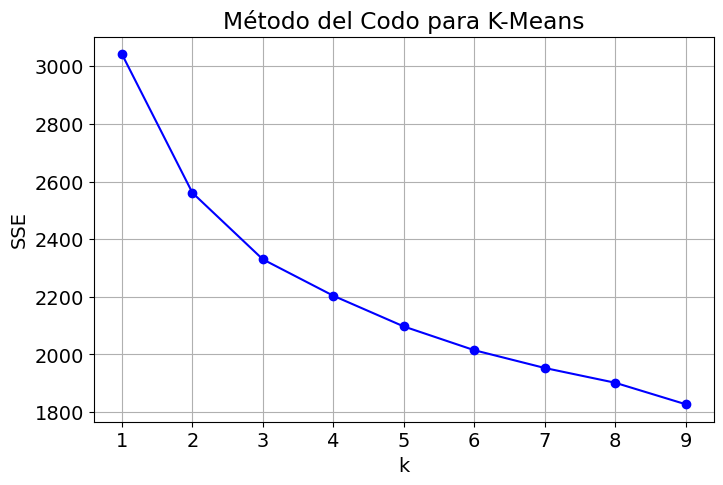

In [69]:
df_pivot = df_reconstruidas.pivot_table(index=None, columns='hora', values=df_reconstruidas.columns[1:])
#df_pivot = pd.DataFrame(df_reconstruidas_frec).T
# Definir el rango de clusters a probar
k_values = range(1, 10)  # Probamos de 1 a 10 clusters

# Usar solo las columnas de df_reconstruidas, donde cada columna es un usuario
X = df_pivot.values  # Las señales reconstruidas de cada usuario

# Lista para almacenar la suma de los errores cuadráticos (SSE)
sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # La inercia es la suma de los errores cuadráticos

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, 'bo-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Método del Codo para K-Means')
plt.grid(True)
plt.show()


Si se eligiera un número mayor alejado de 3 (el codo), puede ocurrir overfitting y generar clusters de un solo usuario. Esto no significa que estos usuarios sean outliers sino que el ajuste de los clusters es de tan poco SSE que termina ajustando a uno solo. 4 clusters es un buen número para elegir en este caso.

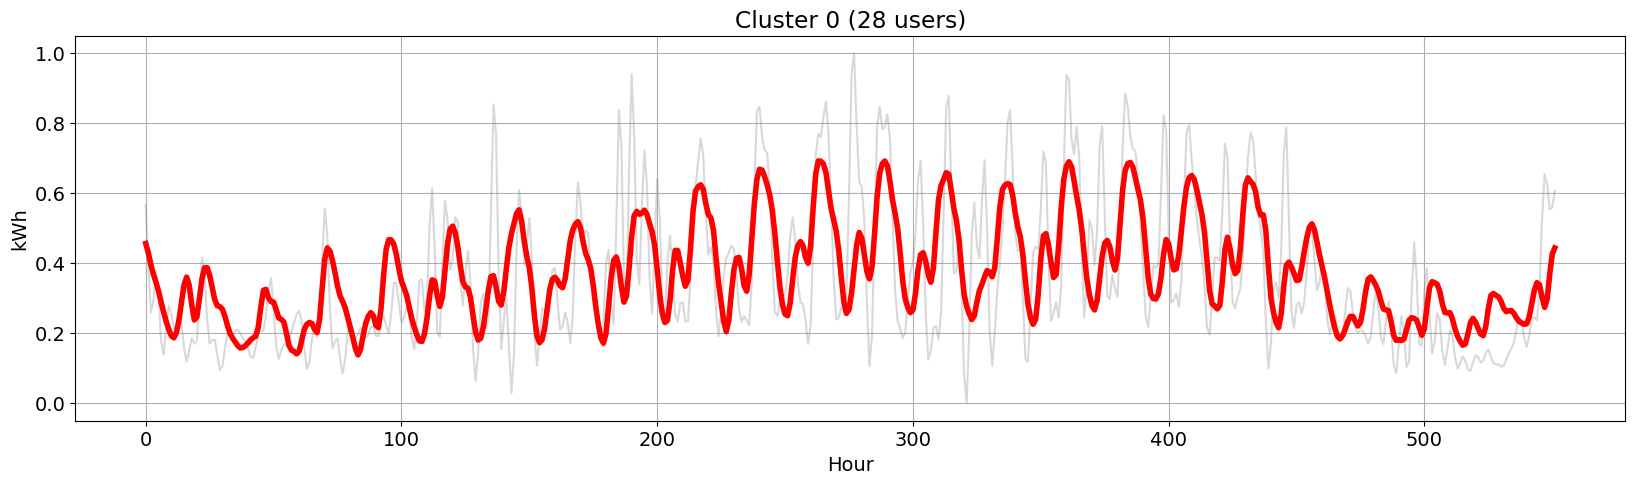

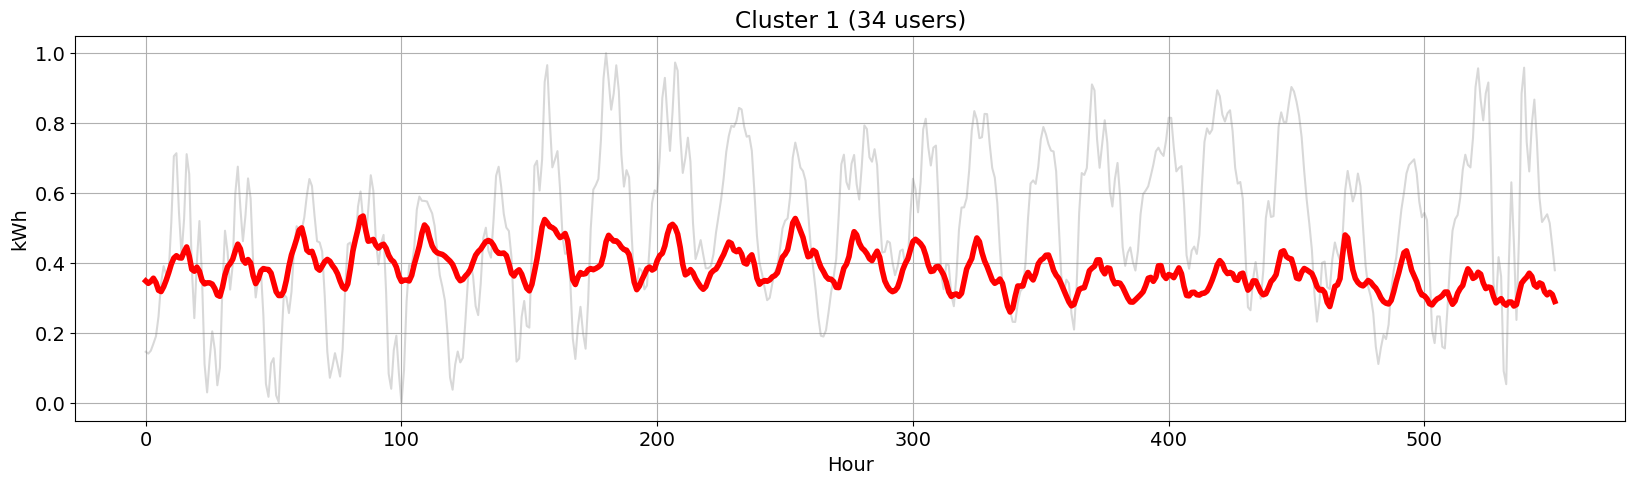

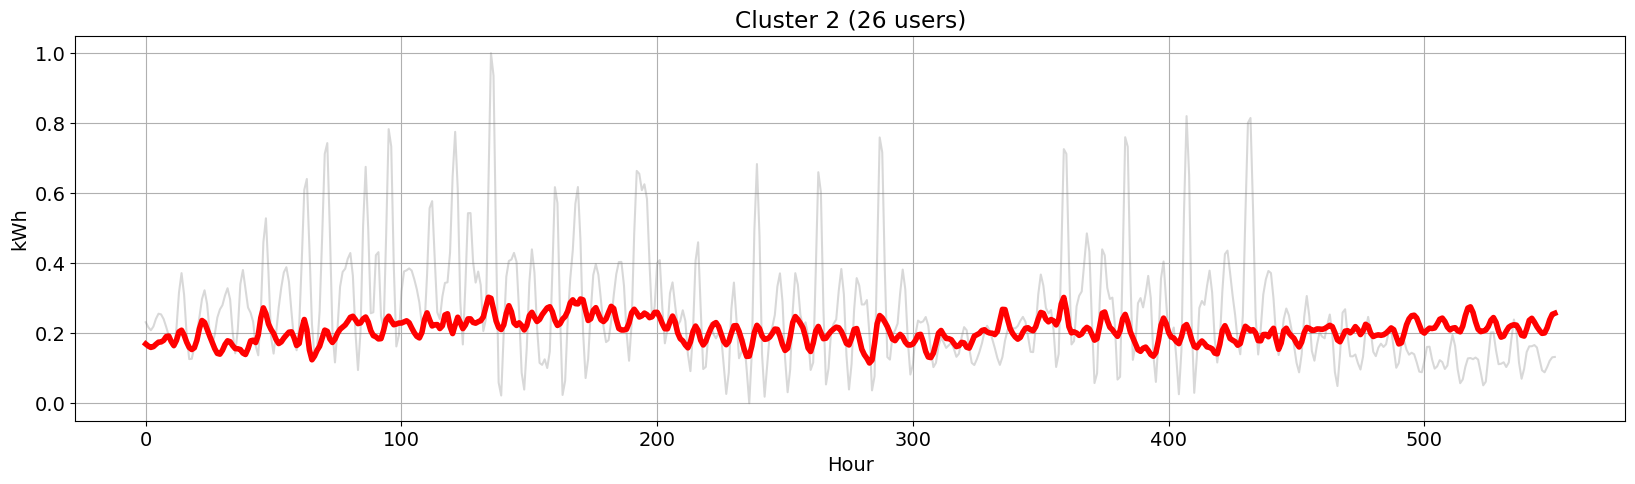

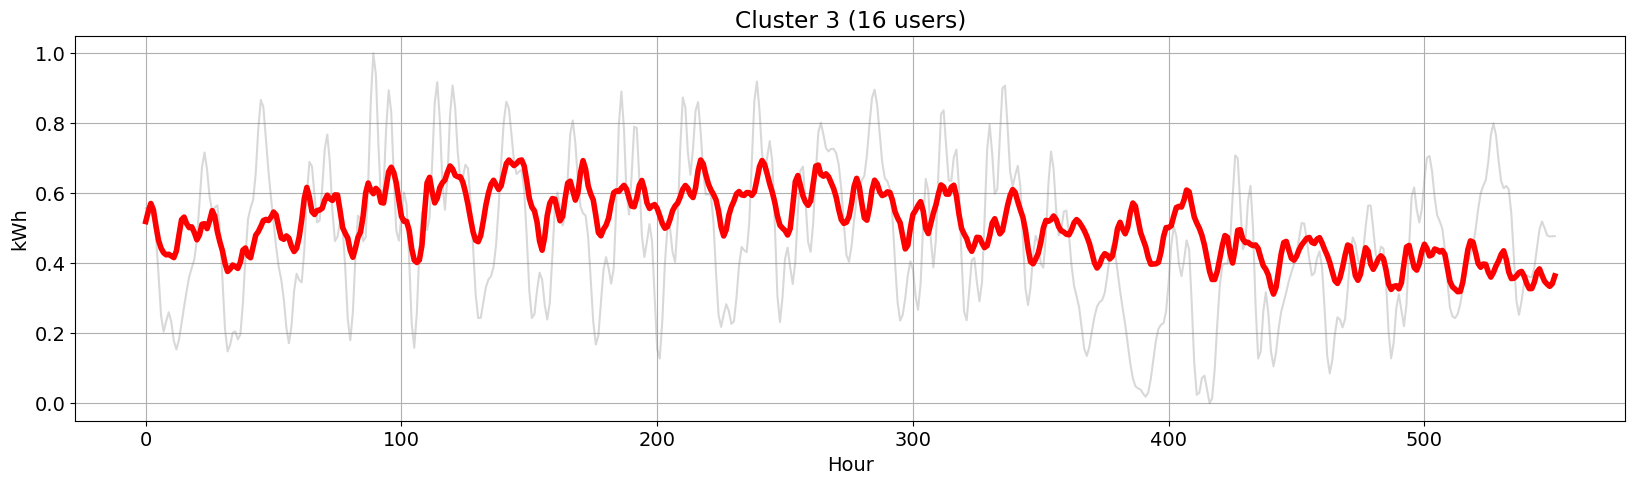

<Figure size 640x480 with 0 Axes>

In [76]:
# Pivotar el dataframe para tener las horas en las columnas y NIS (usuarios) como filas
df_pivot = df_reconstruidas.pivot_table(index=None, columns='hora', values=df_reconstruidas.columns[1:])
#df_pivot = pd.DataFrame(df_reconstruidas_frec).T

X = df_pivot.values  # Datos de las señales reconstruidas

# Número de clusters obtenido previamente
num_clusters = 4

# Aplicar K-Means sobre estas curvas de 24 dimensiones
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df_pivot['cluster'] = kmeans.fit_predict(X)  # Asignar los clusters a los usuarios

for i in range(num_clusters):
    cluster_data = df_pivot[df_pivot['cluster'] == i].drop(columns='cluster')
    cluster_size = len(cluster_data)  # Cantidad de muestras en el cluster

    plt.figure(figsize=(20, 5))

    ### Graficar curvas de usuarios en GRIS ###
    c = 0
    for _, row in cluster_data.iterrows():
        if c >= 1:
            break

        plt.plot(row.index, row.values, color='gray', alpha=0.3)
        c += 1

    # Graficar la curva promedio del cluster en ROJO
    cluster_mean = cluster_data.mean()
    plt.plot(cluster_mean.index, cluster_mean.values, color='red', linewidth=4)

    # Graficar la curva centroide del cluster en AZUL
    #centroide = kmeans.cluster_centers_[i]
    #plt.plot(cluster_mean.index, centroide, color='blue', linestyle='--', linewidth=3, label="Centroide del Cluster")

    # Configuración de cada plot con la cantidad de muestras
    plt.title(f'Cluster {i} ({cluster_size} users)')
    plt.xlabel('Hour')
    plt.ylabel('kWh')
    #plt.xlim(0, 23)
    #plt.ylim(0, 4.5)
    plt.grid(True)
    plt.show()

plt.tight_layout()


In [71]:
clusters_info = {}

for i in range(num_clusters):
    users_in_cluster = df_pivot[df_pivot['cluster'] == i].index.tolist()
    clusters_info[f'Cluster {i}'] = users_in_cluster

# Mostrar los usuarios por cluster
for cluster, users in clusters_info.items():
    print(f"{cluster}: {users}")

Cluster 0: ['102', '106', '107', '112', '115', '121', '127', '129', '136', '141', '142', '143', '144', '157', '159', '53', '59', '60', '63', '69', '72', '74', '76', '83', '86', '90', '92', '93']
Cluster 1: ['101', '105', '108', '110', '128', '130', '132', '137', '147', '148', '149', '150', '151', '152', '155', '161', '163', '164', '166', '167', '52', '58', '65', '66', '79', '80', '81', '89', '91', '94', '95', '97', '98', '99']
Cluster 2: ['100', '103', '104', '111', '114', '118', '119', '122', '123', '125', '133', '135', '146', '153', '160', '168', '55', '61', '62', '67', '71', '73', '78', '84', '87', '88']
Cluster 3: ['109', '113', '117', '120', '126', '134', '145', '156', '158', '162', '56', '64', '68', '70', '77', '82']


In [72]:
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

X = df_pivot.values

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

labels = kmeans.fit_predict(X)

score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.1262


In [73]:
from sklearn.metrics import calinski_harabasz_score

X = df_pivot.values

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

labels = kmeans.fit_predict(X)

score = calinski_harabasz_score(X, labels)
    
print(f"Calinski-Harabasz Score: {score:.4f}")

Calinski-Harabasz Score: 14.3273
